In [ ]:
# Flow ->
# Load data abd clean it
# save data in sqllite table
# query the table to group data based on date and hour and extract info like #transactions, #users and sum of transactions
# query the table to get the highest transaction hour each day

import pandas as pd
import sqlite3

# Load and clean CSV
df = pd.read_csv('/content/sample_transaction_data.csv')
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Save to SQLite
conn = sqlite3.connect('/content/transactions.db')
df.to_sql('transactions_data', conn, if_exists='replace', index=False)

63

In [ ]:
## Task 1 --- Metrics for every date-hour combination
metrics= """
SELECT
    DATE(date) AS transaction_date,
    CAST(strftime('%H', date) AS INTEGER) AS transaction_hour,
    COUNT(*) AS total_transactions,
    COUNT(DISTINCT user_id) AS unique_users,
    SUM(transaction_amount) AS total_transaction_amount
FROM transactions_data
GROUP BY transaction_date, transaction_hour
ORDER BY transaction_date, transaction_hour;
"""

df_metrics = pd.read_sql_query(metrics, conn)
print("Metrics Per Date-Hour")
df_metrics.head()


Metrics Per Date-Hour


,transaction_date,transaction_hour,total_transactions,unique_users,total_transaction_amount
0,2022-04-05,15,1,1,598.74
1,2022-04-06,15,1,1,598.74
2,2022-04-07,9,2,2,746.24
3,2022-04-07,11,2,2,647.72
4,2022-04-07,13,2,2,634.92


In [ ]:
##Task 2 --- Highest transaction hour per date
highest_transaction = """
SELECT
    transaction_date,
    transaction_hour,
    highest_transaction_amount
FROM (
    SELECT
        DATE(date) AS transaction_date,
        CAST(strftime('%H', date) AS INTEGER) AS transaction_hour,
        SUM(transaction_amount) AS highest_transaction_amount,
        RANK() OVER (PARTITION BY DATE(date) ORDER BY SUM(transaction_amount) DESC) AS rk
    FROM transactions_data
    GROUP BY transaction_date, transaction_hour
)
WHERE rk = 1;
"""

df_highest_transaction = pd.read_sql_query(highest_transaction, conn)
print("Highest transaction hour per date:")
df_highest_transaction

Highest transaction hour per date:


,transaction_date,transaction_hour,highest_transaction_amount
0,2022-04-05,15,598.74
1,2022-04-06,15,598.74
2,2022-04-07,17,982.43
3,2022-04-23,15,798.74
4,2022-07-05,15,2834.76
5,2022-07-06,15,2834.76
6,2022-07-09,15,3433.50
7,2022-11-04,17,749.90
8,2023-03-04,9,946.46
9,2023-05-24,13,616.99


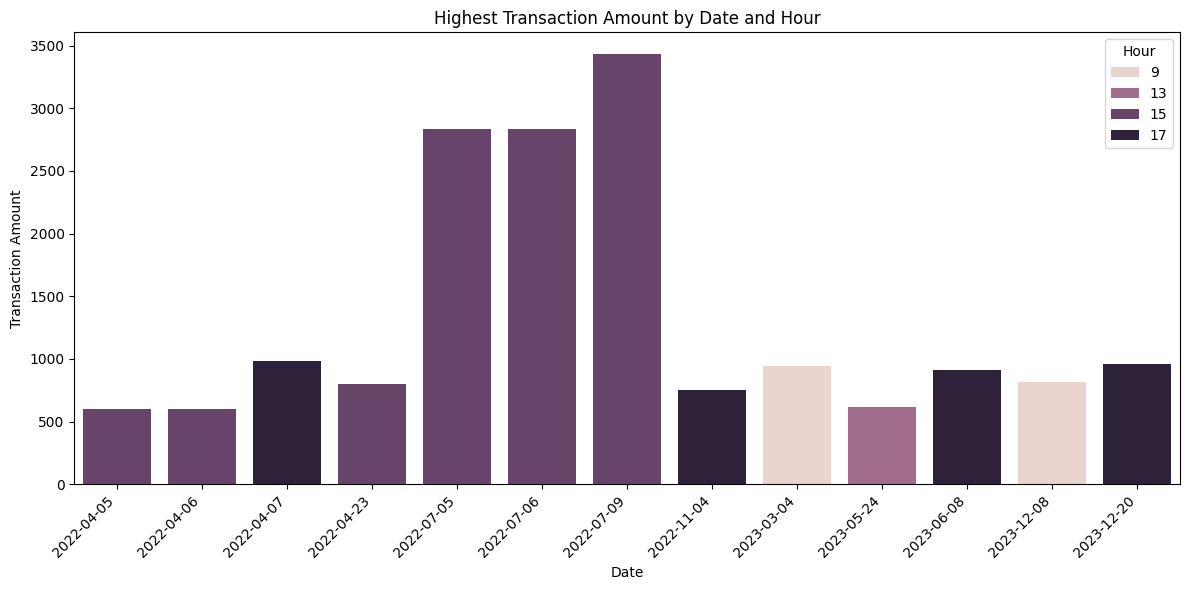

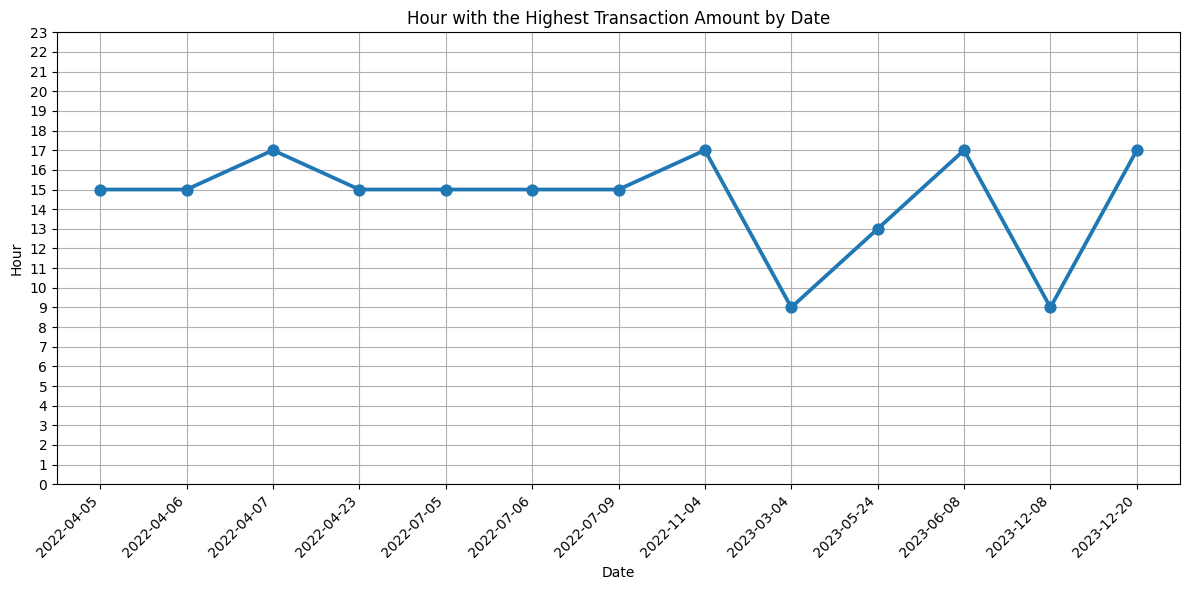

In [21]:
# plot highest transaction hour

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='transaction_date', y='highest_transaction_amount', hue='transaction_hour', data=df_highest_transaction)
plt.title('Highest Transaction Amount by Date and Hour')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Hour')
plt.tight_layout()
plt.show()

# plot the hour of the highest transaction amount per day
plt.figure(figsize=(12, 6))
sns.pointplot(x='transaction_date', y='transaction_hour', data=df_highest_transaction, linestyles="-", markers="o")
plt.title('Hour with the Highest Transaction Amount by Date')
plt.xlabel('Date')
plt.ylabel('Hour')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(24)) # Ensure all hours are shown on the y-axis
plt.grid(True)
plt.tight_layout()
plt.show()
